# Tabular_Pancreas + Baron


In [1]:
import os
import glob
import sys
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns

sys.path.append('../')
import src.utils as my_u
from src.utils import df_cp
from src.utils import df_log
from src.utils import df_total20000
from src.utils import df_minmax
from src.utils import df_l2norm
from src.utils import df_zscore
from src.utils import df_meansquare
from src.utils import run_plot


file_list = glob.glob("../dataset/baron/RAW/*mouse*counts.csv")
print(file_list)

['../dataset/baron/RAW/GSM2230761_mouse1_umifm_counts.csv', '../dataset/baron/RAW/GSM2230762_mouse2_umifm_counts.csv']


In [2]:
total_data = pd.DataFrame()
batch_label = []
for ff in file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    total_data = total_data.append(data)
    batch_label += [ff.split('/')[-1].split('_')[1]] * data.shape[0]
    print(total_data.shape)

labels = total_data['assigned_cluster'].values.tolist()
label_set = set(labels)
print(label_set)
print(set(batch_label))

total_data = total_data.iloc[:,2:]

(822, 14880)
(1886, 14880)
{'macrophage', 'T_cell', 'delta', 'immune_other', 'ductal', 'gamma', 'schwann', 'alpha', 'endothelial', 'beta', 'activated_stellate', 'quiescent_stellate', 'B_cell'}
{'mouse1', 'mouse2'}


In [3]:
baron_labels = labels
baron_blabels = batch_label
baron_total_data = total_data

# Tabula Pancreas

In [6]:
file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/Pancreas-counts.csv")
sample_per_class = 200

total_data = pd.DataFrame()
for ff in file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    total_data = pd.concat([total_data, data.iloc[c,]], axis=0)
    #tm_blabels += [x.split('.')[2] for x in data.index]


annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)
com = annot_label['tissue'].index.intersection(total_data.index)
m = annot_label.filter(com, axis=0)
#print(m)
total_data = total_data.filter(com, axis=0)
total_data = pd.concat([total_data, m['cell_ontology_class']],axis =1)

tissue = labels
labels = total_data['cell_ontology_class']
labels = labels.values.tolist()

total_data.pop('cell_ontology_class')
total_data.pop('zsGreen_transgene')
tm_blabels = [x.split('.')[2] for x in total_data.index]

print(set(labels))
print(set(tm_blabels))

{'pancreatic stellate cell', 'pancreatic D cell', 'leukocyte', 'pancreatic A cell', 'pancreatic acinar cell', 'type B pancreatic cell', 'pancreatic ductal cell', 'endothelial cell', 'pancreatic PP cell'}
{'3_10_M', '3_38_F', '3_8_M', '3_39_F'}


In [7]:
tabula_data = total_data
tabula_labels = labels
tabula_blabels = tm_blabels

# Integrate two


In [8]:
common_gene = baron_total_data.columns.intersection(tabula_data.columns)
common_gene

Index(['0610007P14Rik', '0610009B22Rik', '0610009L18Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik', '0610011F06Rik', '0610012G03Rik',
       '0610030E20Rik', '0610037L13Rik',
       ...
       'Zw10', 'Zwilch', 'Zwint', 'Zxdb', 'Zxdc', 'Zyg11b', 'Zyx', 'Zzef1',
       'Zzz3', 'l7Rn6'],
      dtype='object', length=13263)

In [9]:
tabula_data = tabula_data.filter(common_gene)
baron_total_data = baron_total_data.filter(common_gene)
total_data = pd.concat([tabula_data,baron_total_data], axis=0)
labels =  tabula_labels + baron_labels
blabels = tabula_blabels + baron_blabels
print(total_data.shape)
print(set(labels))
print(len(blabels),set(blabels))

(3213, 13263)
{'macrophage', 'immune_other', 'activated_stellate', 'delta', 'leukocyte', 'type B pancreatic cell', 'pancreatic ductal cell', 'B_cell', 'T_cell', 'ductal', 'gamma', 'pancreatic acinar cell', 'beta', 'quiescent_stellate', 'pancreatic PP cell', 'pancreatic stellate cell', 'pancreatic D cell', 'schwann', 'alpha', 'pancreatic A cell', 'endothelial', 'endothelial cell'}
3213 {'mouse1', '3_39_F', 'mouse2', '3_10_M', '3_38_F', '3_8_M'}


# Label integration

In [10]:
new_lab = []
for x in labels:
    try:
        x=x.replace('pancreatic A cell', 'alpha')
    except:
        pass
    try:
        x=x.replace('endothelial cell', 'endothelial')
    except:
        pass
    try:
        x=x.replace('pancreatic D cell', 'delta')
    except:
        pass
    try:
        x=x.replace('pancreatic acinar cell', 'acinar')
    except:
        pass
    try:
        x=x.replace('pancreatic ductal cell', 'ductal')
    except:
        pass
    try:
        x=x.replace('type B pancreatic cell', 'beta')
    except:
        pass
    try:
        x=x.replace('pancreatic stellate cell', 'stellate')
    except:
        pass
    try:
        x=x.replace('activated_stellate', 'stellate')
    except:
        pass
    try:
        x=x.replace('quiescent_stellate', 'stellate')
    except:
        pass
    new_lab.append(x)

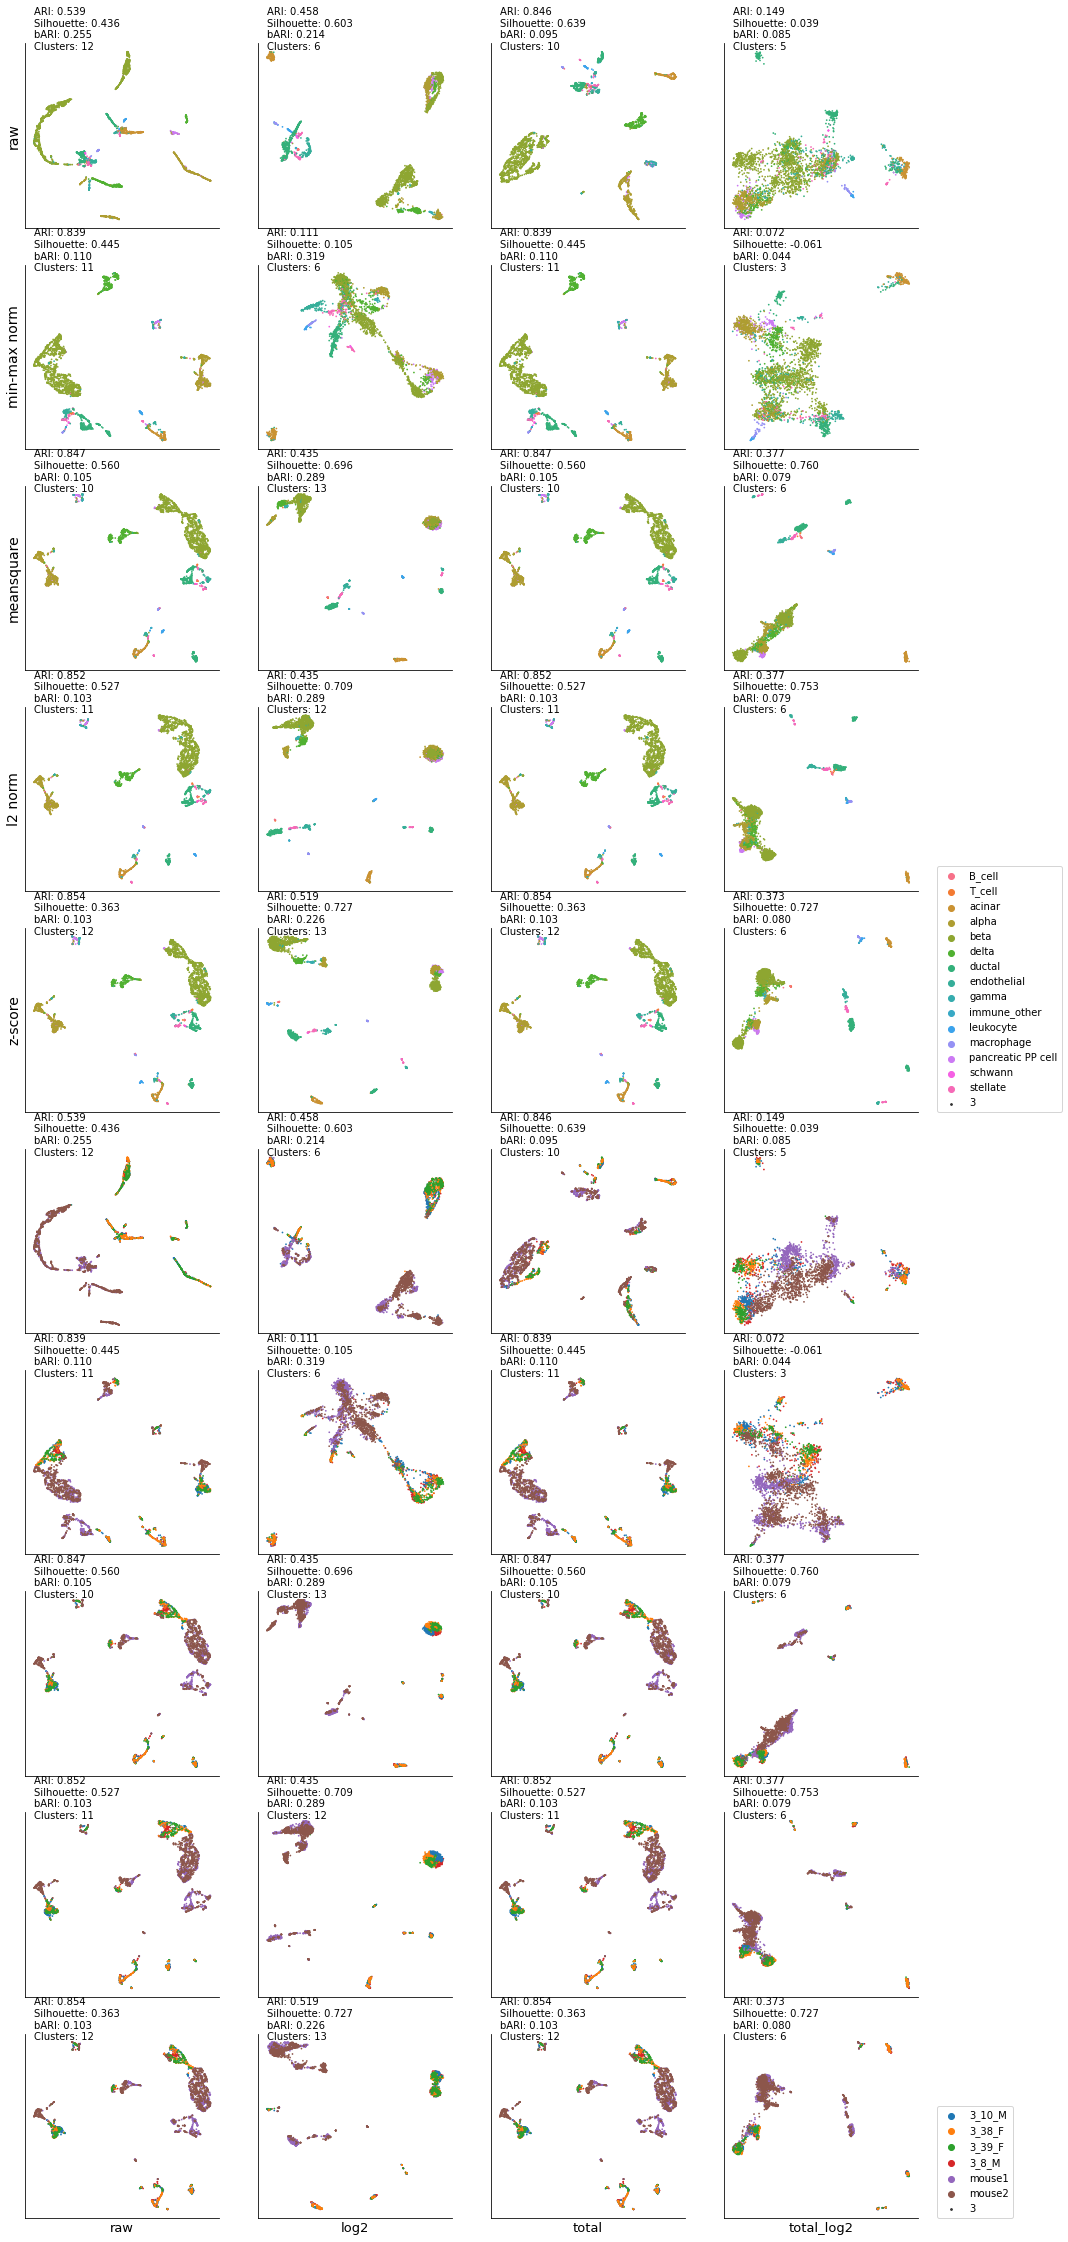

In [11]:
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_cp(total_data), \
         ax00, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )
############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

In [ ]:
rr = pd.DataFrame(l)
plt.figure(figsize=(5,5))
ax = plt.subplot()
ax.scatter(rr.loc[:,1],rr.loc[:,2], c=rr.index, cmap='rainbow',)
plt.xlim(0.0,1)
plt.ylim(0.0,1)

#plt.xlabel('ARI')
#plt.ylabel('Silhouette')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.get_xaxis().set_ticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
#ax.get_yaxis().set_ticks([0.4,0.5,0.6,0.7])

In [ ]:
rr = pd.DataFrame(l)
plt.figure(figsize=(5,5))
ax = plt.subplot()
ax.scatter(rr.loc[:,1],rr.loc[:,2], c=rr.index, cmap='rainbow',)
for i in range(20):
    #ax.annotate(str(i), (r.loc[i,1], r.loc[i,2]),xytext=(r.loc[i,2]-np.random.normal(0, 0.03), r.loc[i,2] -np.random.normal(0, 0.03)),arrowprops=dict(arrowstyle="->"))
    ax.annotate(str(i), (rr.loc[i,1], rr.loc[i,2]),xytext=(rr.loc[i,1]-np.random.normal(0, 0.2), rr.loc[i,2] -np.random.normal(0, 0.07)),arrowprops=dict(arrowstyle="->"))

plt.xlim(0.0,1)
plt.ylim(0.0,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.get_xaxis().set_ticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
#ax.get_yaxis().set_ticks([0.4,0.5,0.6,0.7])



In [ ]:
r = pd.DataFrame(l)
plt.figure(figsize=(5,5))
ax = plt.subplot()
ax.scatter(r.loc[:,1],(1-r.loc[:,3]), c=r.index, cmap='rainbow',)
plt.xlim(0.0,1)
plt.ylim(0.5,1.09)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.get_xaxis().set_ticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
#ax.get_yaxis().set_ticks([0.4,0.5,0.6,0.7])

In [ ]:
r = pd.DataFrame(l)
plt.figure(figsize=(5,5), dpi=300)
ax = plt.subplot()
ax.scatter(r.loc[:,1],(1-r.loc[:,3]), c=r.index, cmap='rainbow',)
for i in range(20):
    #ax.annotate(str(i), (r.loc[i,1], r.loc[i,3]),xytext=(r.loc[i,1]-np.random.normal(0, 0.03), 1-r.loc[i,3] -np.random.normal(0, 0.03)),arrowprops=dict(arrowstyle="->"))
    ax.annotate(str(i), (r.loc[i,1], 1-r.loc[i,3]),xytext=(r.loc[i,1]-np.random.normal(0, 0.2), 1-r.loc[i,3] -np.random.normal(0, 0.1)),arrowprops=dict(arrowstyle="->"))

plt.xlim(0.0,1)
plt.ylim(0.5,1.09)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.get_xaxis().set_ticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
#ax.get_yaxis().set_ticks([0.4,0.5,0.6,0.7])


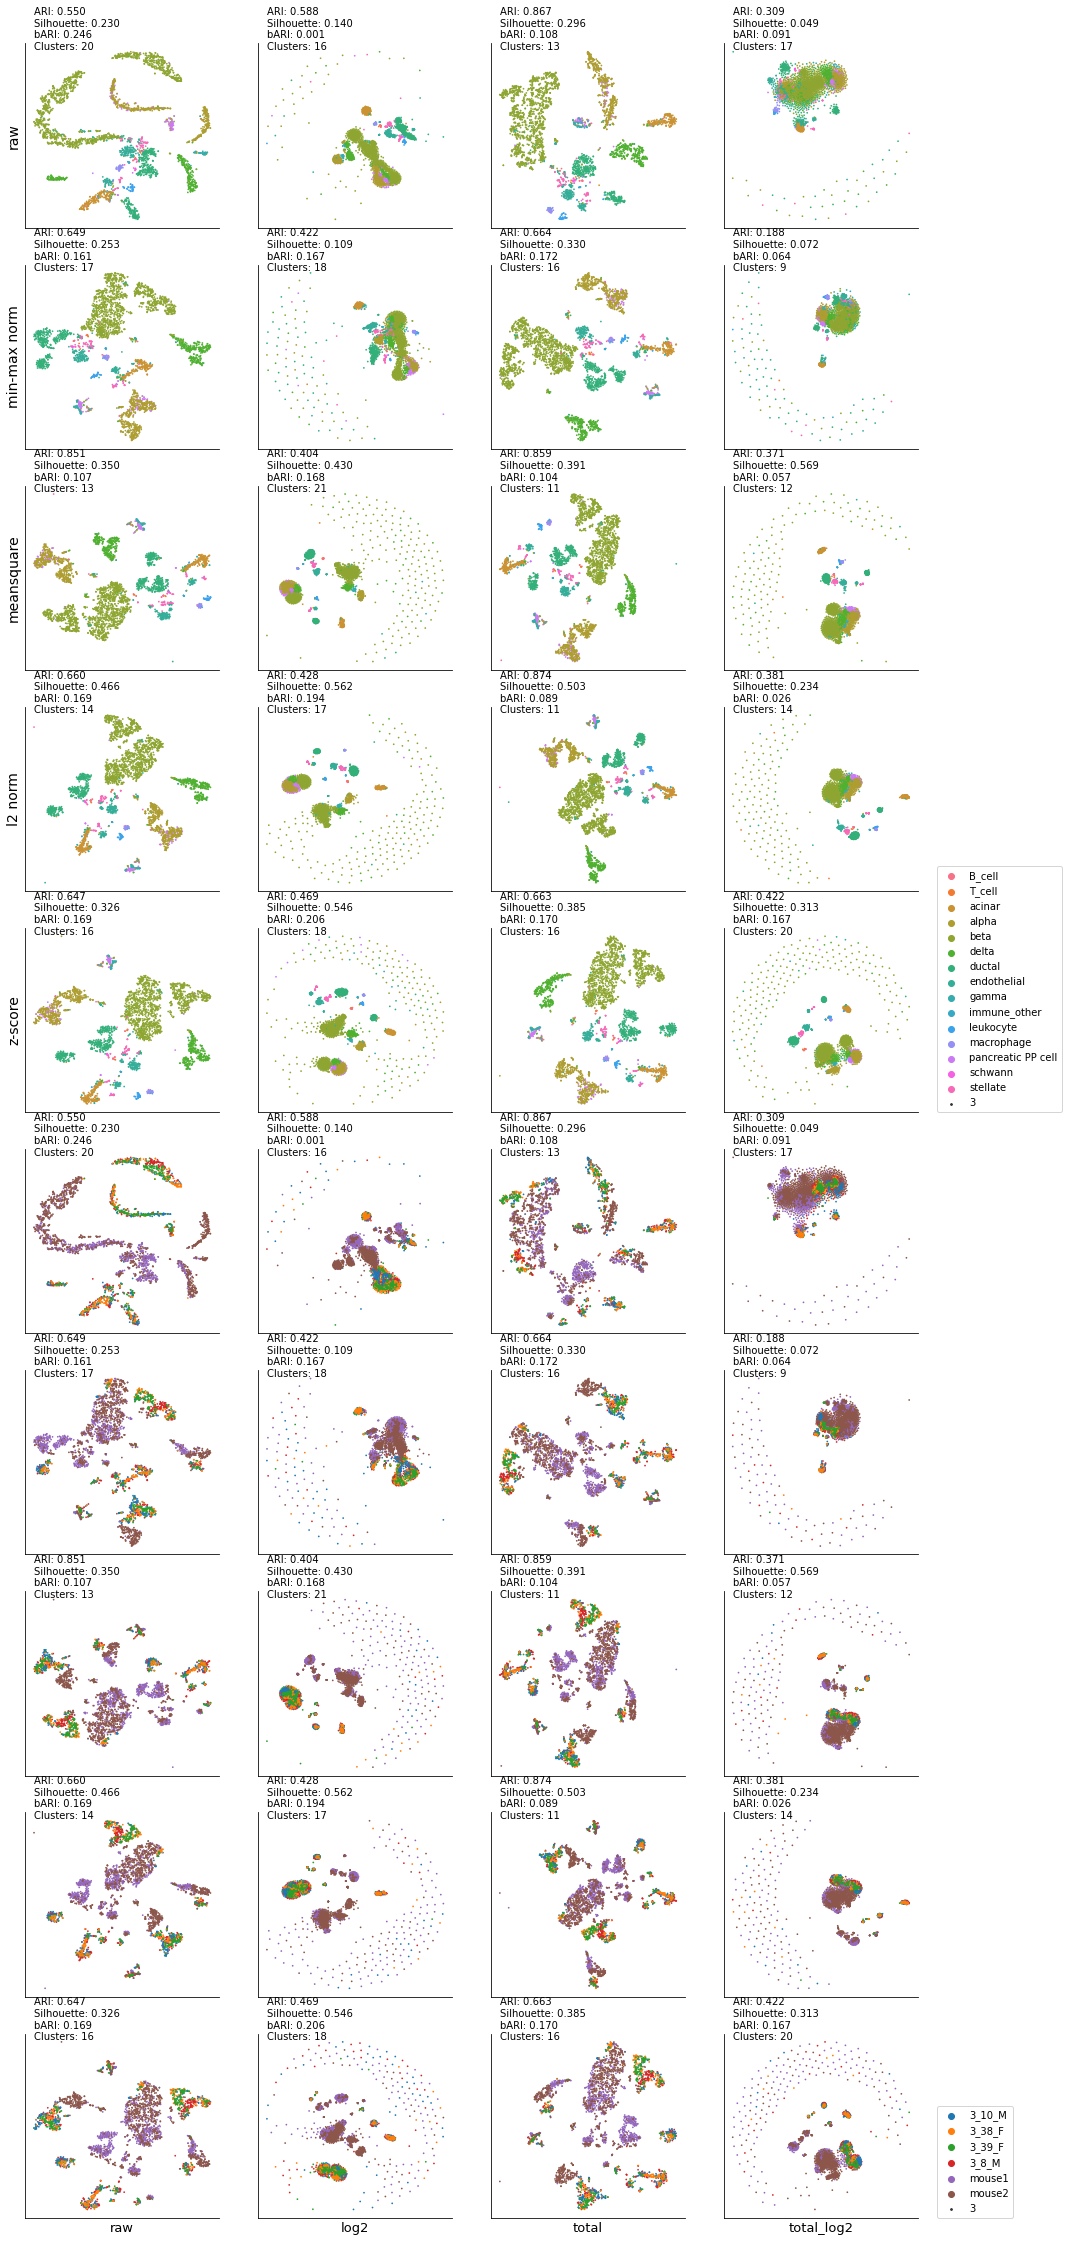

In [12]:
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = TSNE(n_components=2)
l.append(run_plot(df_cp(total_data), \
         ax00, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = TSNE(n_components=2)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = TSNE(n_components=2)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = TSNE(n_components=2)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = TSNE(n_components=2)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, new_lab, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )
############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)